Auteur: Michaël Leroy

 Graph depuis gdf Nodes et edges

       * Comptage du nombre de fois ou une commune est dans un path
       * Comptabilisation en fonction de la longueur totale du trajet (quantile cuts)

        .....

In [1]:
class CFG:
    data_path = './osm_datas/'
    data_path_mappers = './datas'
    path_paths = './tourism_paths'
    score_path = './tourism_scores'
    area_name = 'france'

    cuts = 10

    

import os
os.environ['USE_PYGEOS'] = '0'

import joblib
joblib.dump(
    CFG, 
    os.path.join(
        CFG.score_path,
        'CFG_for_tourism_score_qcuts.pkl'
    ) 
)   


# %load_ext autoreload
# %autoreload


# %aimport OSM_helper_functions
# %aimport OCM_helper_functions

import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import geopandas as gpd
import pandas as pd
import osmnx as ox
import networkx as nx
from tqdm.notebook import tqdm
# from OSM_helper_functions import *
# from OCM_helper_functions import *


ox.settings.log_console=True
ox.settings.use_cache=True
''' To retrieve http data from OSMnx and cache them locally
    before building graph. Raise and exception if requests
    are all done. intercept then set to False and retry.'''
# ox.settings.cache_only_mode=True 



C:\Users\demo\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


' To retrieve http data from OSMnx and cache them locally\n    before building graph. Raise and exception if requests\n    are all done. intercept then set to False and retry.'

In [2]:
Nodes = joblib.load(os.path.join(CFG.data_path, f'[{CFG.area_name}]Gnodes_communes.pkl'))

In [3]:
for _, _, files in os.walk(CFG.path_paths):
    dfs = [ joblib.load(
        os.path.join(CFG.path_paths, file)
    ) for file in files if file.startswith('f')]


In [4]:
paths_df = pd.concat(dfs, axis=0, ignore_index=True)   
paths_df 

,start,goal,path,distance,duration
0,70279,382620,"[70227, 70333, 70330, 70295, 422156, 73911, 38...",125072.247,6190.9
1,70279,2194867,"[70227, 70198, 70258, 70592, 73928, 73936, 108...",497284.011,26570.0
2,70279,906453,"[70227, 70198, 70258, 70592, 73928, 73936, 108...",1080369.844,57932.3
3,70279,960185,"[70227, 70198, 70258, 70592, 73928, 73936, 108...",472196.949,26191.8
4,70279,130427,"[70227, 70333, 70330, 70295, 422156, 73911, 39...",565091.085,30295.4
...,...,...,...,...,...
955535,76306,1268202,"[76340, 85771, 77921, 80091, 173423, 422642, 8...",212753.687,11592.7
955536,76306,125102,"[76340, 85771, 77921, 80091, 173423, 422642, 8...",573113.996,31114.1
955537,76306,112497,"[76308, 76310, 76312, 76314, 721854, 1621669, ...",222969.196,10957.1
955538,76306,388818,"[77321, 77530, 368243, 77763, 80299, 80129, 16...",168658.752,8991.4


In [5]:
# Remove paths not found until fix on graph

error_idx = paths_df.path == ['error']
number_of_errors = np.unique(error_idx, return_counts=True)[1][1]
print(f'Number of paths with error: {number_of_errors}')
paths_df = paths_df[~error_idx.values].reset_index(drop=True)
paths_df

Number of paths with error: 1515


,start,goal,path,distance,duration
0,70279,382620,"[70227, 70333, 70330, 70295, 422156, 73911, 38...",125072.247,6190.9
1,70279,2194867,"[70227, 70198, 70258, 70592, 73928, 73936, 108...",497284.011,26570.0
2,70279,906453,"[70227, 70198, 70258, 70592, 73928, 73936, 108...",1080369.844,57932.3
3,70279,960185,"[70227, 70198, 70258, 70592, 73928, 73936, 108...",472196.949,26191.8
4,70279,130427,"[70227, 70333, 70330, 70295, 422156, 73911, 39...",565091.085,30295.4
...,...,...,...,...,...
954020,76306,1268202,"[76340, 85771, 77921, 80091, 173423, 422642, 8...",212753.687,11592.7
954021,76306,125102,"[76340, 85771, 77921, 80091, 173423, 422642, 8...",573113.996,31114.1
954022,76306,112497,"[76308, 76310, 76312, 76314, 721854, 1621669, ...",222969.196,10957.1
954023,76306,388818,"[77321, 77530, 368243, 77763, 80299, 80129, 16...",168658.752,8991.4


In [6]:
paths_df['labels'] = pd.qcut(
    paths_df['distance'].values.flatten() / 1e3, 
    CFG.cuts, 
    precision=0, 
    ) 
paths_df['intervals'] = paths_df['labels']  
paths_df = paths_df.set_index('labels', drop=True).sort_index().reset_index(drop=True)
paths_df

,start,goal,path,distance,duration,intervals
0,70279,382620,"[70227, 70333, 70330, 70295, 422156, 73911, 38...",125072.247,6190.9,"(3.0, 213.0]"
1,120965,49636,"[192369, 192398, 192382, 192697, 185724, 18571...",92934.568,5430.8,"(3.0, 213.0]"
2,18000,2108928,"[1664393, 23763, 34167, 1920758, 22242, 22270,...",153685.798,7794.4,"(3.0, 213.0]"
3,120965,88847,"[164210, 123352, 164290, 122827, 138739, 79639...",183122.689,10625.7,"(3.0, 213.0]"
4,18000,2924251,"[18316, 23324, 23315, 23804, 23895, 27529, 276...",55896.963,3438.0,"(3.0, 213.0]"
...,...,...,...,...,...,...
954020,139610,287413,"[139269, 135856, 135799, 135782, 132493, 13246...",1013406.440,52349.1,"(952.0, 1603.0]"
954021,52399,75935,"[52398, 9072045, 1402689, 113079, 2885406, 288...",988701.767,52751.3,"(952.0, 1603.0]"
954022,1076124,5815487,"[1189520, 610960, 547854, 547855, 446248, 4469...",973558.644,50311.0,"(952.0, 1603.0]"
954023,139610,114104,"[139269, 135856, 135799, 135782, 132493, 13246...",966432.248,52451.2,"(952.0, 1603.0]"


In [7]:
bins = pd.unique(paths_df['intervals'].values.flatten())
bins

array([Interval(3.0, 213.0, closed='right'),
       Interval(213.0, 317.0, closed='right'),
       Interval(317.0, 407.0, closed='right'),
       Interval(407.0, 488.0, closed='right'),
       Interval(488.0, 563.0, closed='right'),
       Interval(563.0, 637.0, closed='right'),
       Interval(637.0, 719.0, closed='right'),
       Interval(719.0, 821.0, closed='right'),
       Interval(821.0, 952.0, closed='right'),
       Interval(952.0, 1603.0, closed='right')], dtype=object)

In [8]:
scores_df = pd.DataFrame(index= Nodes.index)
scores_df[bins] = [0] * CFG.cuts
scores_df

,"(3.0, 213.0]","(213.0, 317.0]","(317.0, 407.0]","(407.0, 488.0]","(488.0, 563.0]","(563.0, 637.0]","(637.0, 719.0]","(719.0, 821.0]","(821.0, 952.0]","(952.0, 1603.0]"
osmid,,,,,,,,,,
2531584,0,0,0,0,0,0,0,0,0,0
279376,0,0,0,0,0,0,0,0,0,0
1022241,0,0,0,0,0,0,0,0,0,0
153920,0,0,0,0,0,0,0,0,0,0
111919,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
71694,0,0,0,0,0,0,0,0,0,0
5827802,0,0,0,0,0,0,0,0,0,0
2573037,0,0,0,0,0,0,0,0,0,0


  0%|          | 0/10 [00:00<?, ?it/s]

(3.0, 213.0]km, counts:95403


  0%|          | 0/95403 [00:00<?, ?it/s]

(213.0, 317.0]km, counts:95402


  0%|          | 0/95402 [00:00<?, ?it/s]

(317.0, 407.0]km, counts:95403


  0%|          | 0/95403 [00:00<?, ?it/s]

(407.0, 488.0]km, counts:95402


  0%|          | 0/95402 [00:00<?, ?it/s]

(488.0, 563.0]km, counts:95403


  0%|          | 0/95403 [00:00<?, ?it/s]

(563.0, 637.0]km, counts:95402


  0%|          | 0/95402 [00:00<?, ?it/s]

(637.0, 719.0]km, counts:95402


  0%|          | 0/95402 [00:00<?, ?it/s]

(719.0, 821.0]km, counts:95403


  0%|          | 0/95403 [00:00<?, ?it/s]

(821.0, 952.0]km, counts:95402


  0%|          | 0/95402 [00:00<?, ?it/s]

(952.0, 1603.0]km, counts:95403


  0%|          | 0/95403 [00:00<?, ?it/s]

Scored paths: 954025


,"(3.0, 213.0]","(213.0, 317.0]","(317.0, 407.0]","(407.0, 488.0]","(488.0, 563.0]","(563.0, 637.0]","(637.0, 719.0]","(719.0, 821.0]","(821.0, 952.0]","(952.0, 1603.0]",total_count
osmid,,,,,,,,,,,
2531584,0,0,0,0,0,0,0,0,0,0,0
279376,1,1,0,0,1,0,0,0,0,0,3
1022241,0,0,0,0,0,0,0,0,0,0,0
153920,30,94,100,44,37,9,24,4,26,16,384
111919,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
71694,0,0,0,0,0,6,9,30,0,5,50
5827802,14,4,6,4,13,19,10,27,18,23,138
2573037,0,0,0,0,0,0,0,0,0,0,0


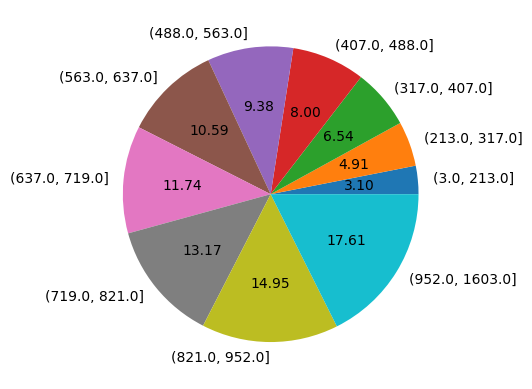

In [10]:
total = 0
for bin in tqdm(bins):
    print(bin, end='km, counts:')
    df = paths_df[paths_df['intervals'].values ==  bin]
    total += df.shape[0]
    print(df.shape[0])
    for _, row in tqdm(df.iterrows(),total=df.shape[0]):
        scores_df.loc[row.path, bin] += 1

    # break
print(f'Scored paths: {total}')


scores_df.sum().plot(kind='pie',autopct='%.2f')  

scores_df['total_count'] = scores_df.sum(axis=1)  

scores_df

In [11]:
scores_df.replace(0,np.nan).dropna(how='all').replace(np.nan,0)

,"(3.0, 213.0]","(213.0, 317.0]","(317.0, 407.0]","(407.0, 488.0]","(488.0, 563.0]","(563.0, 637.0]","(637.0, 719.0]","(719.0, 821.0]","(821.0, 952.0]","(952.0, 1603.0]",total_count
osmid,,,,,,,,,,,
279376,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0
153920,30.0,94.0,100.0,44.0,37.0,9.0,24.0,4.0,26.0,16.0,384.0
414315,280.0,1200.0,769.0,967.0,1159.0,667.0,687.0,952.0,659.0,160.0,7500.0
164862,12.0,30.0,30.0,11.0,24.0,2.0,30.0,16.0,9.0,0.0,164.0
125040,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
111397,231.0,129.0,166.0,128.0,80.0,76.0,152.0,236.0,130.0,87.0,1415.0
3287341,12.0,11.0,9.0,4.0,4.0,11.0,5.0,0.0,11.0,4.0,71.0
133323,13.0,0.0,22.0,54.0,25.0,2.0,1.0,1.0,0.0,0.0,118.0


In [12]:
joblib.dump(
    scores_df,
    os.path.join(
        CFG.score_path,
        'Scores_qcuts.pkl'
    ))

['./tourism_scores\\Scores_qcuts.pkl']

------------------------------